# Import

In [1]:
# Basic Libs
import os
import random
import numpy as np
import pandas as pd

# Image Process
from skimage.data import imread
from skimage.morphology import label

# Model Framework
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Helper Function
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm
from pipeline import *
from evaluation import *
from preprocess import *

Using TensorFlow backend.


# Preprocess

In [2]:
input_dir = '../../ShipDetect/'
train_img_dir = '../../ShipDetect/train/'
test_img_dir = '../../ShipDetect/test/'

In [3]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations_v2.csv')

In [4]:
train_df['isnan'] = train_df['EncodedPixels'].apply(checkNaN)
# Remove toxic image
train_df = train_df[train_df['ImageId'] != '6384c3e78.jpg']

In [5]:
# Remove 100000 Non-ship samples
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[100000:]

In [6]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

In [7]:
train_df_isship = train_df[train_df['area'] > 0]

In [8]:
# Filter data by area less than 10
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]

# Train Data Distribution

In [9]:
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()
train_gp['class'] = train_gp['area'].apply(calc_class)

# Split Train-Valid

In [10]:
train, val = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [11]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

# Data Pipeline

In [12]:
BATCHSIZE = 2
CAP = min(len(train_isship_list),len(train_nanship_list))
datagen = DataPipeline(train_isship_list, train_nanship_list, BATCHSIZE, CAP, train_img_dir, train_df)

# Define Model

In [13]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6),interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [22]:
model.load_weights('../models/checkpoint-baseline.hdf5')

In [23]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# Inference

In [27]:
# Preprocess validation set
val_list = val['ImageId'].tolist()

In [28]:
# Search For Optimal Threshold
scores_list = dict()
threshold_list = [x*1.0/100 for x in range(20,80,10)]

for threshold in threshold_list:
    scores = []
    for i in tqdm(range(len(val_list)//2)):
        temp_list = val_list[i*2:(i+1)*2]
        val_img, val_mask = create_data(temp_list,train_img_dir, train_df)
        pred_mask = model.predict(val_img)
        F2 = calc_score_all_image(val_mask, pred_mask, threshold=threshold)*2
        scores.append(F2)
    val_F2 = np.sum(scores)* (1.0/(len(val_list)//2) *2)
    scores_list[threshold] = val_F2
    
opt_threshold = max(scores_list, key=scores_list.get)

100%|██████████| 463/463 [01:50<00:00,  4.87it/s]


In [29]:
print(scores_list)
print(opt_threshold)

{0.5: 1.9305809156844769, 0.2: 1.6046045876752464, 0.4: 1.8266696295210345, 0.3: 1.7317893705945318, 0.6: 2.0636193214640564, 0.7: 2.1570843857362827}
0.7


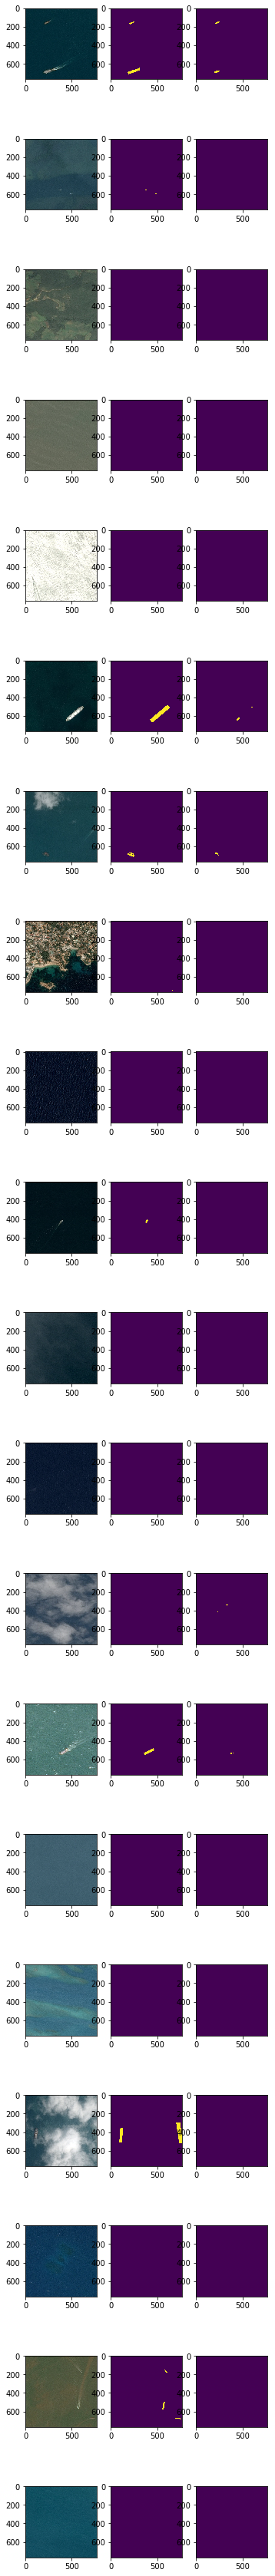

In [30]:
# Show Sample Prediction
image_list = val_list[30:50]
fig, axes = plt.subplots(len(image_list), 3, figsize=(5,5*len(image_list)))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]], train_img_dir, train_df)
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)

# Generate Submission File

In [31]:
test_names = [x.split('.')[0] for x in os.listdir(test_img_dir)]

In [ ]:
pred_rows = []
for name in tqdm(test_names):
    test_img = imread(test_img_dir + name + '.jpg')
    test_img_1 = test_img.reshape(1,768,768,3)/255.0
    test_img_2 = test_img_1[:, :, ::-1, :]
    test_img_3 = test_img_1[:, ::-1, :, :]
    test_img_4 = test_img_1[:, ::-1, ::-1, :]
    pred_prob_1 = model.predict(test_img_1)
    pred_prob_2 = model.predict(test_img_2)
    pred_prob_3 = model.predict(test_img_3)
    pred_prob_4 = model.predict(test_img_4)
    pred_prob = (pred_prob_1 + pred_prob_2[:, :, ::-1, :] + pred_prob_3[:, ::-1, :, :] + pred_prob_4[:, ::-1, ::-1, :])*1.0/4
    pred_mask = pred_prob > opt_threshold
    rles = multi_rle_encode(pred_mask)
    if len(rles)>0:
        for rle in rles:
            pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': rle}]
    else:
        pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': None}]

 10%|█         | 1583/15606 [08:08<55:12:52, 14.17s/it]

In [ ]:
submission_df = pd.DataFrame(pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)